In [1]:
import requests
from bs4 import BeautifulSoup
import nltk
import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
articles = [
  "https://apolitical.co/en/solution_article/how-climate-change-adds-fuel-to-the-refugee-crisis",
  "https://apolitical.co/en/solution_article/how-wigan-drove-change-by-putting-people-first",
  "https://apolitical.co/en/solution_article/what-ghana-can-teach-us-about-integrating-refugees",
  "https://apolitical.co/en/solution_article/does-free-public-transport-actually-work",
  "https://apolitical.co/en/solution_article/the-city-of-the-future-is-built-on-open-data",
  "https://apolitical.co/en/solution_article/no-city-limits-how-data-is-helping-shape-urban-health-policy",
  "https://apolitical.co/en/solution_article/syria-displaced-doctors-turkey-workforce",
  "https://apolitical.co/en/solution_article/local-councils-citizens-collaboration",
  "https://apolitical.co/en/solution_article/reasons-to-be-cheerful-about-the-future-of-local-government",
  "https://apolitical.co/en/solution_article/a-case-for-copying-brazils-refugee-policy",
  "https://apolitical.co/en/solution_article/building-safer-and-more-resilient-cities-in-the-philippines",
  "https://apolitical.co/en/solution_article/regional-australia-needs-immigrants-but-forcing-them-there-isnt-the-answer",
  "https://apolitical.co/en/solution_article/a-small-town-solution-to-digitisation",
  "https://apolitical.co/en/solution_article/smart-cities-are-nothing-without-their-citizens",
  "https://apolitical.co/en/solution_article/what-joining-local-government-feels-like-for-a-junior-public-servant",
]

Part One: Scraping
------------------
Created a basic script that replaces the url to api end point for all the articles, makes a simple GET request for all articlels, and then checks for status code not to be 429 and retrieves the json. If status code is 429, then waits for 10mins and retries for 10 times before terminating. Once the json is retrieved, the html is converted to text using BeautifulSoup, trailing '.','\r',\n', etc...  are removed for all articles, the following script does just that:



In [3]:
# HTTP requests from the same session retries the API for a total of 10 times, sleeping between retries after 10mins for HTTP status code of 429 "too many requests" until its successfull
def req_url(url):
    for i in range(1,10):
        page = requests.get(url)
        if page.status_code == 429:
            time.sleep(600)
            print(url)
        else:
            break
    return page

In [4]:
# Removes duplicate '.'
def dup_char_remover(input,chr):
    pattern = "(?P<char>[" + re.escape(chr) + "])(?P=char)+"
    output=re.sub(pattern, r"\1", input)
    return output

In [5]:
content_text=[]
for a in articles:
    url= a.replace('/en/solution_article/','/api/articles/articles/;slug=')
    print(url)
    page = req_url(url) # gets http response from url
    if page.status_code==429:
        print('this page is not responding')
        continue
    else:
        content=page.json()['content'] #Retrieves content from Json
        text=BeautifulSoup(content).get_text() # Converts html content from json into simple text
        text=text.replace('\n','').replace('\r','.').replace('\xa0','') # removes escape sequences
        text=dup_char_remover(text,'.')
        content_text.append(text)

https://apolitical.co/api/articles/articles/;slug=how-climate-change-adds-fuel-to-the-refugee-crisis
https://apolitical.co/api/articles/articles/;slug=how-wigan-drove-change-by-putting-people-first
https://apolitical.co/api/articles/articles/;slug=what-ghana-can-teach-us-about-integrating-refugees
https://apolitical.co/api/articles/articles/;slug=does-free-public-transport-actually-work
https://apolitical.co/api/articles/articles/;slug=the-city-of-the-future-is-built-on-open-data
https://apolitical.co/api/articles/articles/;slug=no-city-limits-how-data-is-helping-shape-urban-health-policy
https://apolitical.co/api/articles/articles/;slug=syria-displaced-doctors-turkey-workforce
https://apolitical.co/api/articles/articles/;slug=local-councils-citizens-collaboration
https://apolitical.co/api/articles/articles/;slug=reasons-to-be-cheerful-about-the-future-of-local-government
https://apolitical.co/api/articles/articles/;slug=a-case-for-copying-brazils-refugee-policy
https://apolitical.co/a

The following script standardizes text by converting to lower case  and removing punctuations and numbers

In [ ]:
# def standardize_text(df, text_field):
#   df[text_field] = df[text_field].str.lower()
#   df[text_field] = df[text_field].str.replace(r'(', '') 
#   df[text_field] = df[text_field].str.replace(r')', '')
#   df[text_field] = df[text_field].str.replace(r',', '')
#   df[text_field] = df[text_field].str.replace(r'_', '')
#   df[text_field] = df[text_field].str.replace(r"'", "")
#   df[text_field] = df[text_field].str.replace(r"^[a-z]+\[0-9]+$", "")
#   df[text_field] = df[text_field].str.replace(r"^[0-9]{1,2,3,4,5}$", "")
#   return df

In [6]:
import pandas as pd
import numpy as np
nlt=pd.DataFrame(content_text)
nlt.columns=['Articles']
nlt.head(3)

,Articles
0,This opinion article was written byMaram Ahmed...
1,Imagine being asked to identify and cut £140 m...
2,"This article was written byRya G. Kuewor,Found..."


Data Pre-processing
----------------------------
the following script does these steps:
* Tokenizer: splits the text into words, lowercase the words and remove punctuation.
* All stopwords are removed.
* Words are lemmatized 
* Words are stemmed ,so it's reduced to their root form.



In [7]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(123)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91979\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [9]:
processed_docs =nlt['Articles'].map(preprocess)# Preprocess the articles text, saving the results as ‘processed_docs’

Bag of words
-------------------
* Creates a dictionary from ‘processed_docs’ containing the number of times a word appears in the nlt['Articles'].
* For each articles, created a dictionary reporting how many words and how many times those words appear. Which is saved to ‘bow_corpus’.
* Train our lda model using gensim.models.LdaMulticore and save it to ‘ldamodel_bow’


In [10]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [11]:
bow_corpus=[dictionary.doc2bow(doc) for doc in processed_docs]

In [86]:
from gensim import corpora, models
ldamodel_bow = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics = 15, id2word=dictionary, passes=15)
ldamodel_bow.save('ldamodel_bow.gensim') #Save model
keywords = ldamodel_bow.print_topics(num_words=10)
# Print 10 words occuring in that topic and its relative weight.
for keyword in keywords:
    print(keyword)

(0, '0.031*"climat" + 0.021*"chang" + 0.021*"humanitarian" + 0.014*"girl" + 0.010*"year" + 0.010*"impact" + 0.010*"fund" + 0.010*"disast" + 0.010*"women" + 0.010*"gender"')
(1, '0.001*"data" + 0.001*"citi" + 0.001*"health" + 0.001*"dashboard" + 0.001*"communiti" + 0.001*"public" + 0.001*"work" + 0.001*"staff" + 0.001*"govern" + 0.001*"inform"')
(2, '0.020*"council" + 0.016*"local" + 0.015*"staff" + 0.014*"work" + 0.013*"say" + 0.011*"govern" + 0.011*"chang" + 0.011*"deal" + 0.010*"differ" + 0.010*"peopl"')
(3, '0.027*"citi" + 0.027*"health" + 0.022*"data" + 0.016*"dashboard" + 0.014*"public" + 0.011*"servic" + 0.010*"local" + 0.010*"provid" + 0.009*"communiti" + 0.008*"work"')
(4, '0.012*"servic" + 0.012*"citi" + 0.011*"health" + 0.010*"data" + 0.010*"municip" + 0.009*"public" + 0.008*"urban" + 0.007*"digit" + 0.007*"inform" + 0.006*"govern"')
(5, '0.001*"public" + 0.001*"citi" + 0.001*"transport" + 0.001*"work" + 0.001*"region" + 0.001*"peopl" + 0.001*"local" + 0.001*"council" + 0.001

### Interactive Visualization 

pyLDAvis is a interactive web based visualization package which extracts information from LDA model. 

Here, The bubble size says the importance of the topics in relavance to the data. 

Certain topics are clustered together, this indicates the similarity between topics

From the given data, we can see that the Article 5,6,13 and 15 are clustered 

In [14]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel_bow, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [84]:
for x in range (1,15):
    for index, score in sorted(ldamodel_bow[bow_corpus[x]], key=lambda tup: -1*tup[1]):
        print("\nScore: {}\t \nTopic:{}   {}".format(score, x, lda_model.print_topic(index, 10)))


Score: 0.9987369179725647	 
Topic:1   0.011*"council" + 0.007*"approach" + 0.007*"public" + 0.007*"peopl" + 0.006*"servic" + 0.006*"work" + 0.006*"deal" + 0.005*"say" + 0.005*"chang" + 0.005*"like"

Score: 0.9973178505897522	 
Topic:2   0.023*"refuge" + 0.018*"citi" + 0.016*"region" + 0.012*"brazil" + 0.012*"health" + 0.011*"data" + 0.009*"venezuelan" + 0.009*"communiti" + 0.007*"migrat" + 0.007*"dashboard"

Score: 0.9971716403961182	 
Topic:3   0.013*"transport" + 0.009*"peopl" + 0.009*"public" + 0.008*"free" + 0.008*"fare" + 0.005*"increas" + 0.005*"citi" + 0.005*"refuge" + 0.004*"number" + 0.004*"train"

Score: 0.9980140328407288	 
Topic:4   0.038*"health" + 0.019*"citi" + 0.016*"data" + 0.015*"refuge" + 0.015*"turkey" + 0.013*"syrian" + 0.010*"turkish" + 0.009*"train" + 0.008*"public" + 0.008*"servic"

Score: 0.9982084631919861	 
Topic:5   0.012*"data" + 0.012*"staff" + 0.012*"council" + 0.011*"say" + 0.008*"stakehold" + 0.008*"citi" + 0.008*"work" + 0.008*"deal" + 0.008*"chang" +

 The above clearly shows that document has the highest probability to be part of the topic that our model assigned, which is the accurate classification.
 <br> <br>  <br>  <br>
 
 
 

TF-IDF
-------------------
* Train our lda model using gensim.models.LdaMulticore and save it to ‘ldamodel’


In [91]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
# from pprint import pprint
# for doc in corpus_tfidf:
#     pprint(doc)
#     break
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2,per_word_topics =True)
for idx, topic in lda_model.print_topics(-1):
    print('Score: {}\t \n Topic:  {} \n Words: {}'.format(score, idx, topic))


Score: 0.9974498152732849	 
 Topic:  0 
 Words: 0.053*"refuge" + 0.020*"integr" + 0.017*"migrant" + 0.014*"citi" + 0.012*"health" + 0.012*"econom" + 0.009*"communiti" + 0.008*"ghana" + 0.007*"turkey" + 0.007*"solut"
Score: 0.9974498152732849	 
 Topic:  1 
 Words: 0.017*"urban" + 0.014*"citi" + 0.010*"transport" + 0.010*"peopl" + 0.010*"public" + 0.009*"plan" + 0.009*"like" + 0.009*"solut" + 0.008*"servic" + 0.008*"manag"
Score: 0.9974498152732849	 
 Topic:  2 
 Words: 0.024*"municip" + 0.015*"staff" + 0.013*"servic" + 0.013*"digit" + 0.012*"grey" + 0.011*"adam" + 0.011*"highland" + 0.009*"creat" + 0.009*"public" + 0.008*"govern"
Score: 0.9974498152732849	 
 Topic:  3 
 Words: 0.021*"govern" + 0.019*"citi" + 0.018*"public" + 0.017*"data" + 0.015*"urban" + 0.015*"open" + 0.012*"inform" + 0.011*"citizen" + 0.010*"work" + 0.010*"plan"
Score: 0.9974498152732849	 
 Topic:  4 
 Words: 0.013*"brazil" + 0.012*"refuge" + 0.010*"health" + 0.010*"chang" + 0.009*"climat" + 0.009*"venezuelan" + 0.00

In [16]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [122]:
detokenize=processed_docs.to_frame()
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenize['detokenized_sents'] = detokenize.apply(lambda row: TreebankWordDetokenizer().detokenize(row['Articles']), axis=1)
detokenize['detokenized_sents']

0     opinion articl write bymaram ahm fellow school...
1     imagin ask identifi million budget shrink away...
2     articl write byrya kuewor founder publish worl...
3     articl write enrica papa senior lectur transpo...
4     articl write juan vila director open govern ci...
5     coronavirus crisi sweep globe health data impo...
6     million syrian need humanitarian assist turkey...
7     piec write nigel ball deputi director govern o...
8     piec write nick kimber public polici professio...
9     piec write audrey macklin professor chair huma...
10    articl write madhu raghunath sector leader sus...
11    opinion piec write jack archer region australi...
12    articl write zachari spicer director research ...
13    articl write mathew yarger head smart citi soc...
14    articl write andrew phillip nation manag train...
Name: detokenized_sents, dtype: object

In [201]:
# content_text1=[]
# unseen_document = req_url("https://apolitical.co/api/articles/articles/;slug=what-civic-fellows-bring-to-the-governing-table")
# content=page.json()['content'] #Retrieves content from Json
# text=BeautifulSoup(content).get_text() # Converts html content from json into simple text
# text=text.replace('\n','').replace('\r','.').replace('\xa0','') # removes escape sequences
# text=dup_char_remover(text,'.')
# content_text1.append(text)
# nltx1=pd.DataFrame(content_text1)
# nltx1.columns=['Articles']
# stre=', '.join(map(str, content_text1))
# bow_vector = dictionary.doc2bow(preprocess(stre))
# for index, score in sorted(ldamodel_bow[bow_vector], key=lambda tup: -1*tup[1]):
#     print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    

TF-IDF
----------
The concept inverse document frequency is that words that are more popular is less important. Tf-idf frequencies are computed, and a dataframe is created with a Document-term relation which shows the tf-idf value for each term in a given document. This dataframe will have rows for every article and columns for every word.

In [153]:
# TFIDF solution

from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TFIDF vector for the essay feature with all the words
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,1),use_idf =True)
text_tfidf = vectorizer.fit_transform(detokenize['detokenized_sents'])

# Inorder to select top 5000 words based on IDF get the feature name and IDF values
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = vectorizer.idf_
# Sort the IDF and select the top N features 
Vocab_idf=feature_array[np.argsort(tfidf_sorting)[len(feature_array)-5000:]] # Create a Vocab list to pass to TFIDF vectorizer
idf_value=np.sort(tfidf_sorting)[len(feature_array)-5000:]

# USing the vocabulary create a new TFIDF from train data
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,1),use_idf =True,vocabulary=Vocab_idf, norm='l2').fit(detokenize['detokenized_sents'])
text_tfidf = vectorizer.fit_transform(detokenize['detokenized_sents'])
text_tfidf_DF=pd.DataFrame(text_tfidf.toarray(), columns=vectorizer.get_feature_names())

print('The shape of the TFIDF : ' + str(text_tfidf.shape))
# print(text_tfidf_DF)
# print(text_tfidf)
text_tfidf_DF.head(3)

The shape of the TFIDF : (15, 34)


,local,work,communiti,like,help,govern,credit,write,want,servic,...,chang,contributor,manag,articl,base,challeng,futur,exampl,problem,opportun
0,0.051834,0.000000,0.155502,0.110387,0.220773,0.000000,0.110387,0.110387,0.058802,0.000000,...,0.803230,0.066936,0.000000,0.200807,0.133872,0.066936,0.066936,0.000000,0.133872,0.000000
1,0.225221,0.337831,0.037537,0.159878,0.159878,0.079939,0.039970,0.000000,0.127748,0.255496,...,0.533205,0.000000,0.048473,0.000000,0.048473,0.000000,0.048473,0.048473,0.145420,0.145420
2,0.173318,0.259977,0.519953,0.092275,0.184550,0.092275,0.000000,0.184550,0.098308,0.000000,...,0.000000,0.111907,0.223814,0.111907,0.000000,0.000000,0.000000,0.223814,0.111907,0.223814


kMeans Clustering
--------------------------

Finally, Kmeans algorithm is applied to the clusters the similar articles together.  In order for kMeans needs to initialize k centroids we should find the k, Elbow plot method is one of the method to select number of clusters.

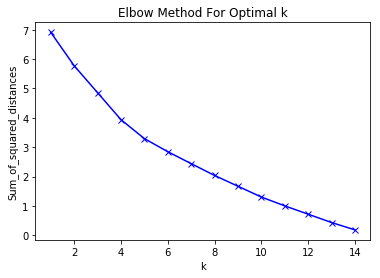

In [154]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(text_tfidf_DF)
    Sum_of_squared_distances.append(km.inertia_)


import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow point is 5. so K is 5

In [155]:
num_clusters=5
km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=100)
km.fit(text_tfidf_DF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [156]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: public peopl servic increas like
Cluster 1: public govern work local develop
Cluster 2: communiti provid area local need
Cluster 3: chang peopl help need work
Cluster 4: servic work govern public need


In [157]:
km.fit(text_tfidf_DF)
text_tfidf_DF['cluster'] = km.labels_
text_tfidf_DF

,local,work,communiti,like,help,govern,credit,write,want,servic,...,contributor,manag,articl,base,challeng,futur,exampl,problem,opportun,cluster
0,0.051834,0.000000,0.155502,0.110387,0.220773,0.000000,0.110387,0.110387,0.058802,0.000000,...,0.066936,0.000000,0.200807,0.133872,0.066936,0.066936,0.000000,0.133872,0.000000,3
1,0.225221,0.337831,0.037537,0.159878,0.159878,0.079939,0.039970,0.000000,0.127748,0.255496,...,0.000000,0.048473,0.000000,0.048473,0.000000,0.048473,0.048473,0.145420,0.145420,3
2,0.173318,0.259977,0.519953,0.092275,0.184550,0.092275,0.000000,0.184550,0.098308,0.000000,...,0.111907,0.223814,0.111907,0.000000,0.000000,0.000000,0.223814,0.111907,0.223814,2
3,0.039082,0.039082,0.000000,0.000000,0.083229,0.000000,0.041615,0.041615,0.000000,0.088671,...,0.000000,0.000000,0.151405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.036783,0.257483,0.036783,0.039167,0.039167,0.626675,0.039167,0.078334,0.041728,0.083456,...,0.047500,0.142500,0.047500,0.095000,0.190000,0.047500,0.190000,0.095000,0.047500,1
5,0.162752,0.108501,0.271253,0.115533,0.173299,0.115533,0.057766,0.000000,0.000000,0.061543,...,0.000000,0.000000,0.000000,0.070056,0.350282,0.070056,0.140113,0.000000,0.070056,2
6,0.000000,0.423640,0.084728,0.000000,0.270658,0.090219,0.000000,0.090219,0.096118,0.672823,...,0.109414,0.000000,0.000000,0.000000,0.109414,0.218827,0.000000,0.109414,0.109414,4
7,0.181801,0.363601,0.303001,0.258111,0.193583,0.258111,0.064528,0.129055,0.068746,0.206239,...,0.000000,0.078256,0.000000,0.078256,0.078256,0.156512,0.000000,0.234769,0.000000,1
8,0.315415,0.245323,0.175231,0.261222,0.111952,0.223905,0.037317,0.074635,0.039757,0.477087,...,0.045257,0.045257,0.000000,0.226285,0.090514,0.000000,0.090514,0.045257,0.045257,1
9,0.065851,0.065851,0.065851,0.140238,0.000000,0.070119,0.070119,0.140238,0.074703,0.448221,...,0.085037,0.085037,0.170075,0.085037,0.000000,0.000000,0.000000,0.255112,0.000000,0


In [202]:
# vectorizer = TfidfVectorizer(max_features=5,use_idf =True).fit(detokenize['detokenized_sents'])
# text_tfidf = vectorizer.fit_transform(detokenize['detokenized_sents'])
# text_tfidf_DF=pd.DataFrame(text_tfidf.toarray(), columns=vectorizer.get_feature_names())
# print('The shape of the TFIDF : ' + str(text_tfidf.shape))
# #print(text_tfidf_DF)
# num_clusters=5
# km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=100)
# km.fit(text_tfidf_DF)
# text_tfidf_DF['cluster'] = km.labels_
# text_tfidf_DF

In [204]:
print(bow_corpus)


[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 3), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 3), (32, 1), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1), (38, 12), (39, 1), (40, 1), (41, 1), (42, 1), (43, 18), (44, 1), (45, 1), (46, 3), (47, 1), (48, 3), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 3), (63, 2), (64, 3), (65, 1), (66, 3), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 6), (78, 4), (79, 1), (80, 1), (81, 2), (82, 1), (83, 2), (84, 2), (85, 1), (86, 1), (87, 1), (88, 3), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 3), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 6), (105, 1), (106, 1), (107, 6), (108, 1), (109, 8), (110, 

# Findings: 

The articles 2,3,8,9,13, and 15 are similar which is simialar to the result in LDA analysis. Similarly, article 1,and 7 are similar, Article 3 and 10 belongs to same cluster,  similar.

In general, cluster 0 appears to have quite a few terms, as it start to look at top words "public", "peopl", "servic" and "increas"" and clusters. Cluster 1 seems to generally be about local devlopment with features like public govern work local and develop.  Cluster 2 seems to have a lot of words suggesting the community related work. Although the limited keyword doesn’t immediately to group, the model could be worth further investigation with large dataset.
